# Simulations for hapmatch chapter

This notebook generates the simulation-based figures used in the hapmatch chapter. These demonstrate the validity of the mathematical analysis of the demographic models and the sensitivity of haplotype segment sharing to demographic parameters.

1. [Tree simulation methods](#tree_sim)
2. [Testing analysis of shared branches](#test_branches) 
3. [Testing analysis of shared mutations](#test_mutations) 
4. [Testing analysis with simulated sequences](#test_sequences) 

In [1]:
from __future__ import division
from __future__ import print_function

import msprime as msp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import itertools
import math

# sns.set_color_codes(palette='deep')
exp = np.exp
multinomial = scipy.stats.multinomial

## 1. Tree simulation methods <a class="anchor" id="tree_sim"></a>

This is the structured demographic model which is analysed in most detail in the hapmatch paper.

In [2]:
def sim_basic_delay(Ne=1e4, delay=400, mu=1.2e-8, length=2500, reps=5000):
    """
    Simulation of three non-recombining sequences with one delayed sample
    """
    population_configurations = [msp.PopulationConfiguration(initial_size=Ne)]
    samples = [msp.Sample(0, 0), msp.Sample(0, 0), msp.Sample(0, delay)]
    
    return msp.simulate(
        population_configurations=population_configurations, 
        mutation_rate=mu,
        length=length,
        samples=samples,
        num_replicates = reps,
    )

        
def sim_structure(Ne=1e4, 
                  join_1=1000, 
                  join_2=500, 
                  merge=2000, 
                  ancestry_1=0.5,
                  ancestry_2=0.5,
                  scale_1=2, 
                  scale_2=2,
                  mu=1.2e-8,
                  length=2500,
                  reps=5000):
    """
    Simulation of three non-recombining sequences with population structure and time-staggered sampling
    """
    if not ancestry_2:
        ancestry_2 = 1 - ancestry_1
    elif ancestry_1 + ancestry_2 > 1:
        raise Exception('Ancestry proportions exceed 1')

    population_configurations = [
        msp.PopulationConfiguration(initial_size=Ne),
        msp.PopulationConfiguration(initial_size=Ne/scale_1),
        msp.PopulationConfiguration(initial_size=Ne/scale_2)
    ]

    samples = [msp.Sample(0, 0), 
               msp.Sample(1, 0), 
               msp.Sample(2, 0),
    ]
    
    if join_2 < join_1:
        ancestry_1 = ancestry_2/(1 - ancestry_1)
        demographic_events = [
            # Modern sample joins ancient population 2 with probability ancestry_2 at time join_2_time
            msp.MassMigration(time=join_2, source=0, destination=2, proportion=ancestry_2),
            
            # Modern sample joins ancient population 1, with adjusted ancestry_1, at time join_1_time
            msp.MassMigration(time=join_1, source=0, destination=1, proportion=ancestry_1),
    
            # Global merge into population 0
            msp.MassMigration(time=merge, source=1, destination=0, proportion=1),
            msp.MassMigration(time=merge, source=2, destination=0, proportion=1),
        ]
        
    else:
        ancestry_2 = ancestry_1/(1 - ancestry_2)
        demographic_events = [
            # Modern sample joins ancient population 1 with probability ancestry_1 at time join_1_time
            msp.MassMigration(time=join_1, source=0, destination=1, proportion=ancestry_1),
            
            # Modern sample joins ancient population 2, with adjusted ancestry_2, at time join_2_time
            msp.MassMigration(time=join_2, source=0, destination=2, proportion=ancestry_2),
    
            # Global merge into population 0
            msp.MassMigration(time=merge, source=1, destination=0, proportion=1),
            msp.MassMigration(time=merge, source=2, destination=0, proportion=1),
        ]

    return msp.simulate(
        population_configurations=population_configurations, 
        mutation_rate=mu,
        length=length,
        samples=samples,
        num_replicates=reps,
        demographic_events = demographic_events
    )

## 2. Testing analysis of shared branches<a class="anchor" id="test_branches"></a>

### Theoretical cumulative distribution of shared branch lengths

In [3]:
def cumulative_shared_branch_length(l, args):
    lmb1, lmb2 = 1/args['scale_1'], 1/args['scale_2']
    t1, t2 = (args['merge'] - args['join_1'])/(2*args['Ne']), (args['merge'] - args['join_2'])/(2*args['Ne'])
    p0 = 0
    p1 = args['ancestry_1']
    p2 = 1 - p1 - p0

    A = p1*(exp(-t1/lmb1)/(lmb1 + 1))
    B = (p0 + p1*exp(-t1/lmb1) + p2*exp(-t2/lmb2))
    F0 = p2*(1 - exp(-t2/lmb2)) + (2/3)*B
    
    if l == 0:
        return F0
    elif l < t1:
        return F0 + A*(lmb1*exp(l/lmb1) + exp(-l) -lmb1 -1) + (B/3)*(1 - exp(-l))
    else:
        Ft1 = F0 + A*(lmb1*exp(t1/lmb1) + exp(-t1) -lmb1 -1) + (B/3)*(1 - exp(-t1))
        return Ft1 + (A*(exp((1 + 1/lmb1)*t1)-1)+B/3)*(exp(-t1) - exp(-l))

### Generate cumulative density plot of shared branch lengths

In [4]:
def plot_cumulative_branch_sharing(args, lines, save_name=None, title=None):    
    x_end = 4
    y_start = 0.4
    
    x = np.arange(0, x_end, 0.01)
    y = [cumulative_shared_branch_length(i, args) for i in x]
        
    for _ in range(lines):
        L = []
        L0 = []
        for s in sim_structure(**args):
            tree = s.trees().next()
            p = tree.get_parent(0)
            if tree.get_parent(1) == p:
                l = tree.get_branch_length(p)/(2*args['Ne'])
                L.append(l)
            else:
                L0.append(0)

        plt.hist(L+L0, bins=500, normed=True, cumulative=True, histtype='step', color='r', 
                 linewidth=0.5, alpha=0.4)
        plt.xlim(0,x_end)
        plt.ylim(y_start,1)
    
    plt.plot(x,y, linewidth=2,label='Theoretical')
    plt.plot(x,[0 for _ in x], linewidth=2, color='r', label='Simulated')
    plt.legend(loc=4, fontsize='large')
    plt.ylabel('Cumulative density', fontsize='large')
    plt.xlabel('Branch length (coalescent units)', fontsize='large')
    
    if save_name:
        plt.savefig(save_name, format=save_name[-3:])
    
    if title:
        plt.title(title, fontsize='large')

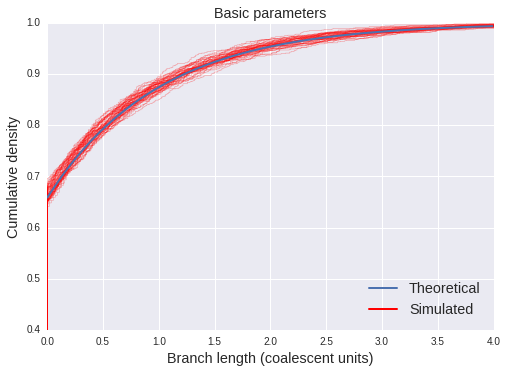

In [5]:
basic_args = {'Ne':1e4, 
        'join_1':500, 
        'join_2':500,
        'merge':1000, 
        'ancestry_1':0.5,
        'ancestry_2':0.5,
        'scale_1':2, 
        'scale_2':2,
        'reps':1000,
        'mu': 1.2e-8,
        'length':2500}

long_args = basic_args.copy()
long_args['join_1'] = 500
long_args['join_2'] = 500
long_args['merge'] = 20000

new_args = basic_args.copy()
new_args['reps'] = 10000

n_args = basic_args.copy()
n_args['ancestry_1'] = 0.7
n_args['ancestry_2'] = 0.3
n_args['scale_1'] = 10
n_args['join_1'] = 0

# plot_cumulative_branch_sharing(basic_args, 50, title='Basic parameters', save_name='BasicParsLineSharing.jpg')
# plot_cumulative_branch_sharing(long_args, 50, title='Late merge time', save_name='LateMergeLineSharing.jpg')
# plot_cumulative_branch_sharing(new_args, 50, title='Additional trees per run', save_name='TreesLineSharing.jpg')
# plot_cumulative_branch_sharing(n_args, 50, title='Increased population 1 branch-sharing', save_name='SharingLineSharing.jpg')

plot_cumulative_branch_sharing(basic_args, 50, title='Basic parameters')
plt.show()


## 3. Testing analysis of shared mutations<a class="anchor" id="test_mutations"></a>

### Analytic expression of private derived allele sharing in each population

In [6]:
def theoretical_match_probs(args):
    lmb1, lmb2 = 1/args['scale_1'], 1/args['scale_2']
    t1, t2 = (args['merge'] - args['join_1'])/(2*args['Ne']), (args['merge'] - args['join_2'])/(2*args['Ne'])
    
    if t1<0 or t2<0:
        raise Exception('Invalid box times: {}, {}'.format(t1,t2))
    
    p1 = args['ancestry_1']
    if 'ancestry_2' in args:
        p2 = args['ancestry_2']
        if p1 + p2 > 1:
            raise Exception('Ancestry proportions exceed 1')
        p0 = 1 - p1 - p2
    else:
        p2 = 1 - p1
        p0 = 0
    
    theta = 4*args['Ne']*args['mu']*args['length']
    B = (p0 + p1*exp(-t1/lmb1) + p2*exp(-t2/lmb2))
    d2 = 1 + theta/2
    
    A = {1:p1*exp(-t1/lmb1)/(lmb1 + 1),
         2:p2*exp(-t2/lmb2)/(lmb2 + 1)}
    d1 = {1: 1/lmb1 - theta/2,
          2: 1/lmb2 - theta/2}   
    t = {1: t1,
         2: t2}
    I0 = {1: p2*(1 - exp(-t2/lmb2)) + (2/3)*B,
          2: p1*(1 - exp(-t1/lmb1)) + (2/3)*B}
    lmb = {1:lmb1,
           2:lmb2}
    
    out = []
    for i in 1,2:
        I = I0[i]
        I += A[i]*(exp(d1[i]*t[i])-1)/d1[i] + A[i]*(exp(-d2*t[i])-1)/d2
        I += A[i]*(exp((1 + 1/lmb[i])*t[i])-1)*(exp(-(1 + theta/2)*t[i]))/d2
        I += B/(3*d2)
        out.append(1-I)
    return out[0], out[1], (out[0]-out[1])/(out[0] + out[1]), out[0]/(out[0] + out[1])

### Generate mutation comparison plots

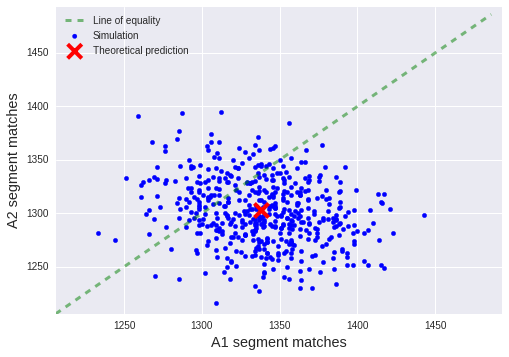

In [7]:
basic_args = {'Ne':1e4, 
        'join_1':800, 
        'join_2':1000,
        'merge':2000, 
        'ancestry_1':0.5,
        'ancestry_2':0.5,
        'scale_1':2, 
        'scale_2':2,
        'reps':10000,
        'mu': 1.2e-8,
        'length':2500}

def compare_simulated_pop_matches(simulation=sim_structure, reps=500, args=basic_args, scatter_plot=False,
                                 save_name=None):
    A1, A2 = [], []
    
    for _ in range(reps):
        a1, a2 = 0, 0
        for s in simulation(**args):
            tree = s.trees().next()
            p = tree.get_parent(0)
            if tree.get_parent(1) == p:
                muts = []
                for m in tree.mutations():
                    if m.node == p:
                        muts.append(m)
                if muts:
                    a1 += 1
            elif tree.get_parent(2) == p:
                muts = []
                for m in tree.mutations():
                    if m.node == p:
                        muts.append(m)
                if muts:
                    a2 += 1
            
        A1.append(a1)
        A2.append(a2)
    
    if scatter_plot:
        plt.scatter(A1, A2, label='Simulation', color='b')
        one,two,r_one, r_two = theoretical_match_probs(args)
        plt.scatter([one*args['reps']],[two*args['reps']], color='r', marker="x", s=200, linewidth=4.0, 
                    label='Theoretical prediction')
        lower = min(A1 + A2) - 10
        upper = max(A1 + A2) + 50

        x = np.arange(lower, upper, 10)
        y = x    
        plt.plot(x,y, '--', color='g', alpha=0.5, label= 'Line of equality', linewidth=3)
        plt.xlabel('A1 segment matches', fontsize='large')
        plt.ylabel('A2 segment matches', fontsize='large')
        plt.xlim(lower, upper)
        plt.ylim(lower, upper)
        plt.legend(loc=2)
        plt.savefig(save_name, format='jpg')
        plt.show()
    
    return A1, A2

out = compare_simulated_pop_matches(args=basic_args, save_name='ScatterMatchComparison.jpg', scatter_plot=True)


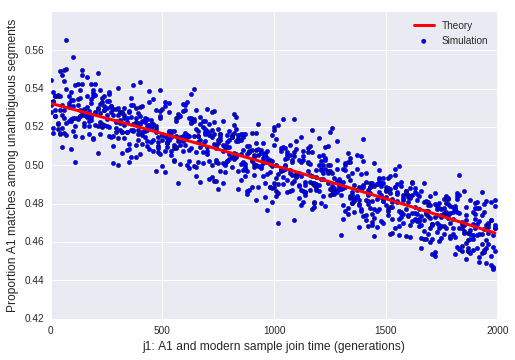

In [8]:
basic_args = {'Ne':1e4, 
        'join_1':500, 
        'join_2':1000,
        'merge':2000, 
        'ancestry_1':0.5,
        'ancestry_2':0.5,
        'scale_1':2, 
        'scale_2':2,
        'reps':10000,
        'mu': 1.2e-8,
        'length':2500}

x = np.arange(0, basic_args['merge'], 10)
y = []
for i in x:
    tmp = basic_args.copy()
    tmp['join_1'] = i
    ratio = theoretical_match_probs(tmp)[-1]
    y.append(ratio)
    for _ in range(5):
        A1, A2 = compare_simulated_pop_matches(args=tmp, reps=1)
        plt.scatter([i],[A1[0]/(A1[0] + A2[0])]) #, [i], sim[1])

plt.scatter([i],[A1[0]/(A1[0] + A2[0])], label='Simulation') 
plt.plot(x,y, color='r', linewidth=3, label='Theory')
plt.legend()
plt.xlim(0, basic_args['merge'])
plt.ylabel('Proportion A1 matches among unambiguous segments', fontsize='medium')
plt.xlabel('j1: A1 and modern sample join time (generations)', fontsize='medium')
plt.savefig('TheorySimMatchComparison.jpg', format='jpg')
plt.show()